# Business Understanding

The goal of this project is to assess the accident risk of small aircraft for business/private use. The client is new to the business of operating aircraft and wants to minimize risk. This also includes focusing on the most common aircraft and newer planes to reduce the number of unknowns that would arise from lesser-used aircraft and the potential for incomplete maintenance records. The client will receive a targeted list of the safest aircraft to analyze further - for cost, number of seats, fuel efficiency, or other factors outside of the scope of this analysis - before making a final purchasing decision.

# Data Understanding

In [22]:
# Import pandas, numpy, and matplotlib.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The data.csv file includes a unique entry for each accident or incident recorded, along with the number of injuries, fatalites, etc., information about the aircraft involved, and the circumstances around the event.

In [23]:
# Load accident data. 
df = pd.read_csv("./data/Aviation_Data.csv", low_memory=False) # Added low-memory=False to solve dtype error warning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

The following is <a href="https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download">aircraft registration data</a> from the FAA. I was looking for data that included how many aircraft are in service, or how many trips or hours were logged, so that I could get an accident rate rather than an absolute number of accidents or injuries, etc. I think it's more meaningful to measure accident rates because if two aircraft have the same number of accidents but one is twice as common, it's likely the safer one. This registration data, specifically, isn't ideal for my purposes, but I think the proportion of aircraft registered compared to the proportion of accidents should be meaningful enough for this purpose.

The two files below are master.txt, which contains the registration data for each aircraft and acftref.txt (aircraft reference), which contains detail information about each aircraft type. The "master" file contains a make/model code number, rather than text, and has to be cross-referenced with the acftref file to get the manufacturer and model names to merge with the accident data based on the make and model. 

In [24]:
# Read csv files from FAA registration database.
master = pd.read_csv('./data/MASTER.txt', low_memory=False)
acftref = pd.read_csv('./data/ACFTREF.txt', low_memory=False)

In [25]:
master.info()
master.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298702 entries, 0 to 298701
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   N-NUMBER          298702 non-null  object 
 1   SERIAL NUMBER     298702 non-null  object 
 2   MFR MDL CODE      298702 non-null  object 
 3   ENG MFR MDL       298702 non-null  object 
 4   YEAR MFR          298702 non-null  object 
 5   TYPE REGISTRANT   298702 non-null  object 
 6   NAME              298702 non-null  object 
 7   STREET            298702 non-null  object 
 8   STREET2           298702 non-null  object 
 9   CITY              298702 non-null  object 
 10  STATE             298702 non-null  object 
 11  ZIP CODE          298702 non-null  object 
 12  REGION            298702 non-null  object 
 13  COUNTY            298702 non-null  object 
 14  COUNTRY           298702 non-null  object 
 15  LAST ACTION DATE  298702 non-null  int64  
 16  CERT ISSUE DATE   29

,N-NUMBER,SERIAL NUMBER,MFR MDL CODE,ENG MFR MDL,YEAR MFR,TYPE REGISTRANT,NAME,STREET,STREET2,CITY,...,OTHER NAMES(2),OTHER NAMES(3),OTHER NAMES(4),OTHER NAMES(5),EXPIRATION DATE,UNIQUE ID,KIT MFR,KIT MODEL,MODE S CODE HEX,Unnamed: 34
0,100,5334,7100510,17003,1940,1,BENE MARY D ...,PO BOX 329,,KETCHUM,...,...,...,...,...,20270430,600060,,,A004B3,NaN
1,10000,10000,2130004,,,7,9AT LLC ...,511 WEDGEWOOD AVE,,NASHVILLE,...,...,...,...,...,20310831,1443200,,,A00725,NaN
2,10001,A28,9601202,67007,1928,1,STOOS ROBERT A ...,PO BOX 1056,,LAKELAND,...,...,...,...,...,20290228,432072,,,A00726,NaN
3,10004,T18208245,2072738,,,7,ETOS AIR LLC ...,PO BOX 288,,NEW LONDON,...,...,...,...,...,20290331,102879,,,A00729,NaN
4,10006,BG-72,1152020,17026,1955,1,COUTCHES ROBERT HERCULES DBA ...,550 AIRWAY BLVD,,LIVERMORE,...,...,...,...,...,20280229,480110,,,A0072B,NaN


In [26]:
acftref.info()
acftref.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92192 entries, 0 to 92191
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CODE            92192 non-null  object 
 1   MFR             92192 non-null  object 
 2   MODEL           92192 non-null  object 
 3   TYPE-ACFT       92192 non-null  object 
 4   TYPE-ENG        92192 non-null  int64  
 5   AC-CAT          92192 non-null  int64  
 6   BUILD-CERT-IND  92192 non-null  int64  
 7   NO-ENG          92192 non-null  int64  
 8   NO-SEATS        92192 non-null  int64  
 9   AC-WEIGHT       92192 non-null  object 
 10  SPEED           92192 non-null  int64  
 11  TC-DATA-SHEET   92192 non-null  object 
 12  TC-DATA-HOLDER  92192 non-null  object 
 13  Unnamed: 13     0 non-null      float64
dtypes: float64(1), int64(6), object(7)
memory usage: 9.8+ MB


,CODE,MFR,MODEL,TYPE-ACFT,TYPE-ENG,AC-CAT,BUILD-CERT-IND,NO-ENG,NO-SEATS,AC-WEIGHT,SPEED,TC-DATA-SHEET,TC-DATA-HOLDER,Unnamed: 13
0,0020901,AAR AIRLIFT GROUP INC,UH-60A,6,3,1,0,2,15,CLASS 3,0,,...,NaN
1,0030109,EXLINE ACE-C,ACE-C,4,1,1,1,1,1,CLASS 1,82,,...,NaN
2,003010D,DELEBAUGH,P,4,1,1,1,1,1,CLASS 1,82,,...,NaN
3,003010H,DAL PORTO,BABY ACE D,4,1,1,1,1,1,CLASS 1,82,,...,NaN
4,003010P,DUNN,BABY ACE,4,1,1,1,1,1,CLASS 1,82,,...,NaN


## Data Preparation

Data Preparation: Notebook shows how you prepare your data and explains why by including…
Instructions or code needed to get and prepare the raw data for analysis
Code comments and text to explain what your data preparation code does
Valid justifications for why the steps you took are appropriate for the problem you are solving

### Data Cleaning and processing - Aviation_Data.csv

In [27]:
# Drop columns I won't be using.
reduced_df = df.drop(['Event.Id', 'Accident.Number', 'Location', 'Country', 'Latitude', 'Longitude', "Airport.Code", 'Schedule', 'Airport.Name', 'Registration.Number', 'Publication.Date', 'Air.carrier'], axis=1)

# Format make and model columns as strings, then combine to create a single make/model entry.
reduced_df['Make'].astype('str')
reduced_df['Model'].astype('str')
reduced_df['make.model'] = reduced_df['Make'] + " " + reduced_df['Model']
reduced_df['make.model'].astype('str')
reduced_df.drop(['Make', 'Model'], axis=1)

# Make upper case for consistency.
reduced_df['make.model'] = reduced_df['make.model'].str.upper()

There are a number of rows with dates in the "Investigation.Type" column and no data in any of the other columns. There are two columns that appear to have dates in them: "Event.Date" and "Publication.Date". "Event.Date" has the same number of entries, 88889, as "Event.Id" and "Accident.Number", and is probably not coincidentally the same as the number of "Accident" and "Incident" entries. That suggests to me that "Event.Date" is fully populated and there are 88889 valid entries in this database. It appears that "Publication.Date" has missing entries on each row before each of the "Investigation.Type" anomalies. My best guess it that these dates probably correlate to the previous row's "Publication.Date". Since I have no plans to use publication date in my analysis, I am going to simply remove those rows rather than trying to correct them.

In [28]:
index_to_remove = reduced_df[ (reduced_df['Investigation.Type'] != 'Accident') & (reduced_df['Investigation.Type'] != 'Incident') ].index
reduced_df.drop(index_to_remove, inplace=True)
assert reduced_df['Investigation.Type'].value_counts().sum() == 88889

In [29]:
# Drop rows that are missing Make or Model info. 
reduced_df.dropna(subset=['Model', 'Make'], inplace=True)

In [30]:
# Format Event.Date as date and trim to only count recent data (the last 10 complete years)
reduced_df['Event.Date'] = pd.to_datetime(reduced_df['Event.Date'])
reduced_df = reduced_df[reduced_df['Event.Date'] > '2013-1-1'].copy() 

In [31]:
# Sum accident data to get totals
accident_sums = reduced_df.groupby(['make.model']).sum().reset_index()

# Add number of occurrences of something happening to a plane. I am treating 
# both accidents and incidents as causes for concern and therefore including both.
occurrence = reduced_df.value_counts('make.model').reset_index()
occurrence.columns = ['make.model', 'occurrences']
accident_sums = pd.merge(accident_sums, occurrence, left_on='make.model', right_on='make.model', how='inner')

### Data Cleaning and processing - FAA Registration Data

In [32]:
# Only keep aircraft with 20 seats or less.
acftref_reduced = acftref[acftref['NO-SEATS'] <= 20]

# Set the indices for each new dataframe to the manufacturer/model code and join them to bring the
# manufacturer/model text to the master registration data.
master.set_index('MFR MDL CODE', inplace=True)
acftref_reduced.set_index('CODE', inplace=True)
master = master.join(acftref_reduced)

In [33]:
# Create a new dataframe with each row representing a make/model and number of registered aircraft. 
acft_grouped = master.groupby(['MFR', 'MODEL']).count().reset_index()
acft_grouped = acft_grouped[['N-NUMBER','MFR','MODEL']]
# Sort to see most common aircraft.
acft_grouped.sort_values(by=['N-NUMBER'], ascending=False, inplace=True)

In [34]:
# Create manufacturer/model column to merge with accident data
acft_grouped['mfr.model'] = acft_grouped['MFR'].str.strip() + " " + acft_grouped['MODEL'].str.strip()
acft_grouped['mfr.model'].astype('str').str.upper();

## Data Analysis

### Merge Accident and Registration Data

In [35]:
# Merge registration data with accident data and drop redundant columns.
merged = pd.merge(accident_sums, acft_grouped, left_on='make.model', right_on='mfr.model', how='inner')
merged.sort_values(by='N-NUMBER', ascending=False, inplace=True)
merged.drop(columns=['mfr.model','MFR','MODEL'], inplace=True)

# Add columns with data normalized by number of registered planes.
merged['fatalities.per.plane'] = merged['Total.Fatal.Injuries']/merged['N-NUMBER']
merged['serious.per.plane'] = merged['Total.Serious.Injuries']/merged['N-NUMBER']
merged['minor.per.plane'] = merged['Total.Minor.Injuries']/merged['N-NUMBER']
merged['uninjured.per.plane'] = merged['Total.Uninjured']/merged['N-NUMBER']
merged['occurrences.per.plane'] = merged['occurrences']/merged['N-NUMBER']

# Add number of people effected per plane column
merged['total.people.effected.per.plane'] = merged['fatalities.per.plane']+merged['serious.per.plane']+merged['minor.per.plane']+merged['uninjured.per.plane']

# Reset number of engines to be per plane (this column was summed earlier)
# and create top ten lists for single and dual engine aircraft.
merged['Number.of.Engines'] = round(merged['Number.of.Engines']/merged['occurrences'], 0)
merged['Number.of.Engines'].value_counts()
single_eng_top_ten = merged[merged['Number.of.Engines'] == 1].head(10)
dual_eng_top_ten = merged[merged['Number.of.Engines'] == 2].head(10)
dual_eng_top_ten

,make.model,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,occurrences,N-NUMBER,fatalities.per.plane,serious.per.plane,minor.per.plane,uninjured.per.plane,occurrences.per.plane,total.people.effected.per.plane
1236,PIPER PA-23-250,2.0,12.0,1.0,2.0,9.0,11,908,0.013216,0.001101,0.002203,0.009912,0.012115,0.026432
1262,PIPER PA-30,2.0,14.0,1.0,1.0,27.0,21,879,0.015927,0.001138,0.001138,0.030717,0.023891,0.048919
337,BOMBARDIER INC BD-100-1A10,2.0,0.0,0.0,2.0,8.0,2,794,0.000000,0.000000,0.002519,0.010076,0.002519,0.012594
205,BEECH 95-B55 (T42A),2.0,4.0,2.0,1.0,4.0,7,777,0.005148,0.002574,0.001287,0.005148,0.009009,0.014157
550,CESSNA 560XL,2.0,7.0,0.0,0.0,45.0,10,624,0.011218,0.000000,0.000000,0.072115,0.016026,0.083333
1281,PIPER PA-34-200T,2.0,7.0,2.0,0.0,11.0,13,566,0.012367,0.003534,0.000000,0.019435,0.022968,0.035336
523,CESSNA 340A,2.0,19.0,0.0,0.0,12.0,14,552,0.034420,0.000000,0.000000,0.021739,0.025362,0.056159
537,CESSNA 421C,2.0,16.0,5.0,0.0,12.0,13,505,0.031683,0.009901,0.000000,0.023762,0.025743,0.065347
1013,LEARJET INC 45,2.0,0.0,6.0,0.0,6.0,2,460,0.000000,0.013043,0.000000,0.013043,0.004348,0.026087
1288,PIPER PA-44-180,2.0,2.0,0.0,0.0,12.0,7,370,0.005405,0.000000,0.000000,0.032432,0.018919,0.037838


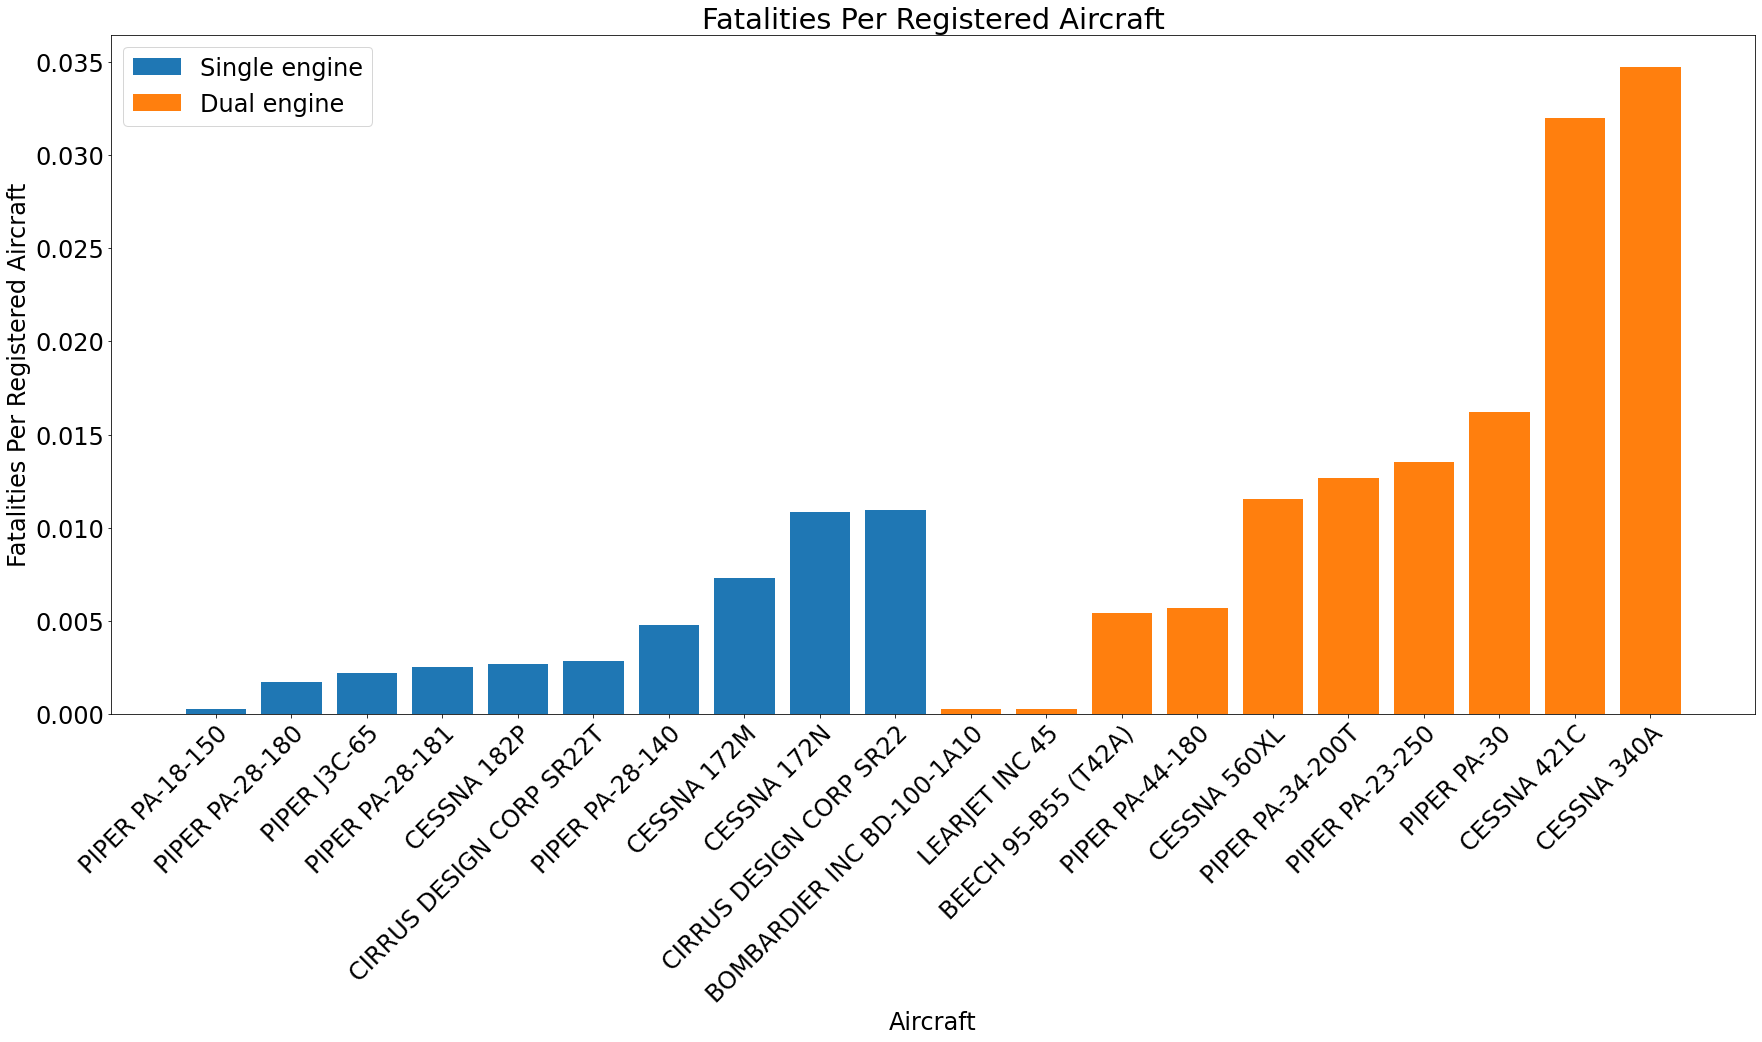

In [36]:
single_eng_top_ten.sort_values('fatalities.per.plane', inplace=True)
x = single_eng_top_ten['make.model']
y = single_eng_top_ten['fatalities.per.plane']
dual_eng_top_ten.sort_values('fatalities.per.plane', inplace=True)
x2 = dual_eng_top_ten['make.model']
y2 = dual_eng_top_ten['fatalities.per.plane']

plt.rcParams['font.size'] = 24
plt.figure(figsize=(25, 15))
plt.bar(x, y+.0003, label='Single engine') # added a small amount so that bars with value = 0 would show
plt.bar(x2, y2+.0003, label='Dual engine')
plt.xlabel("Aircraft")
plt.ylabel("Fatalities Per Registered Aircraft")
plt.title("Fatalities Per Registered Aircraft")
plt.xticks(rotation=45, ha="right", wrap=True)
plt.tight_layout()
plt.legend()
plt.show()

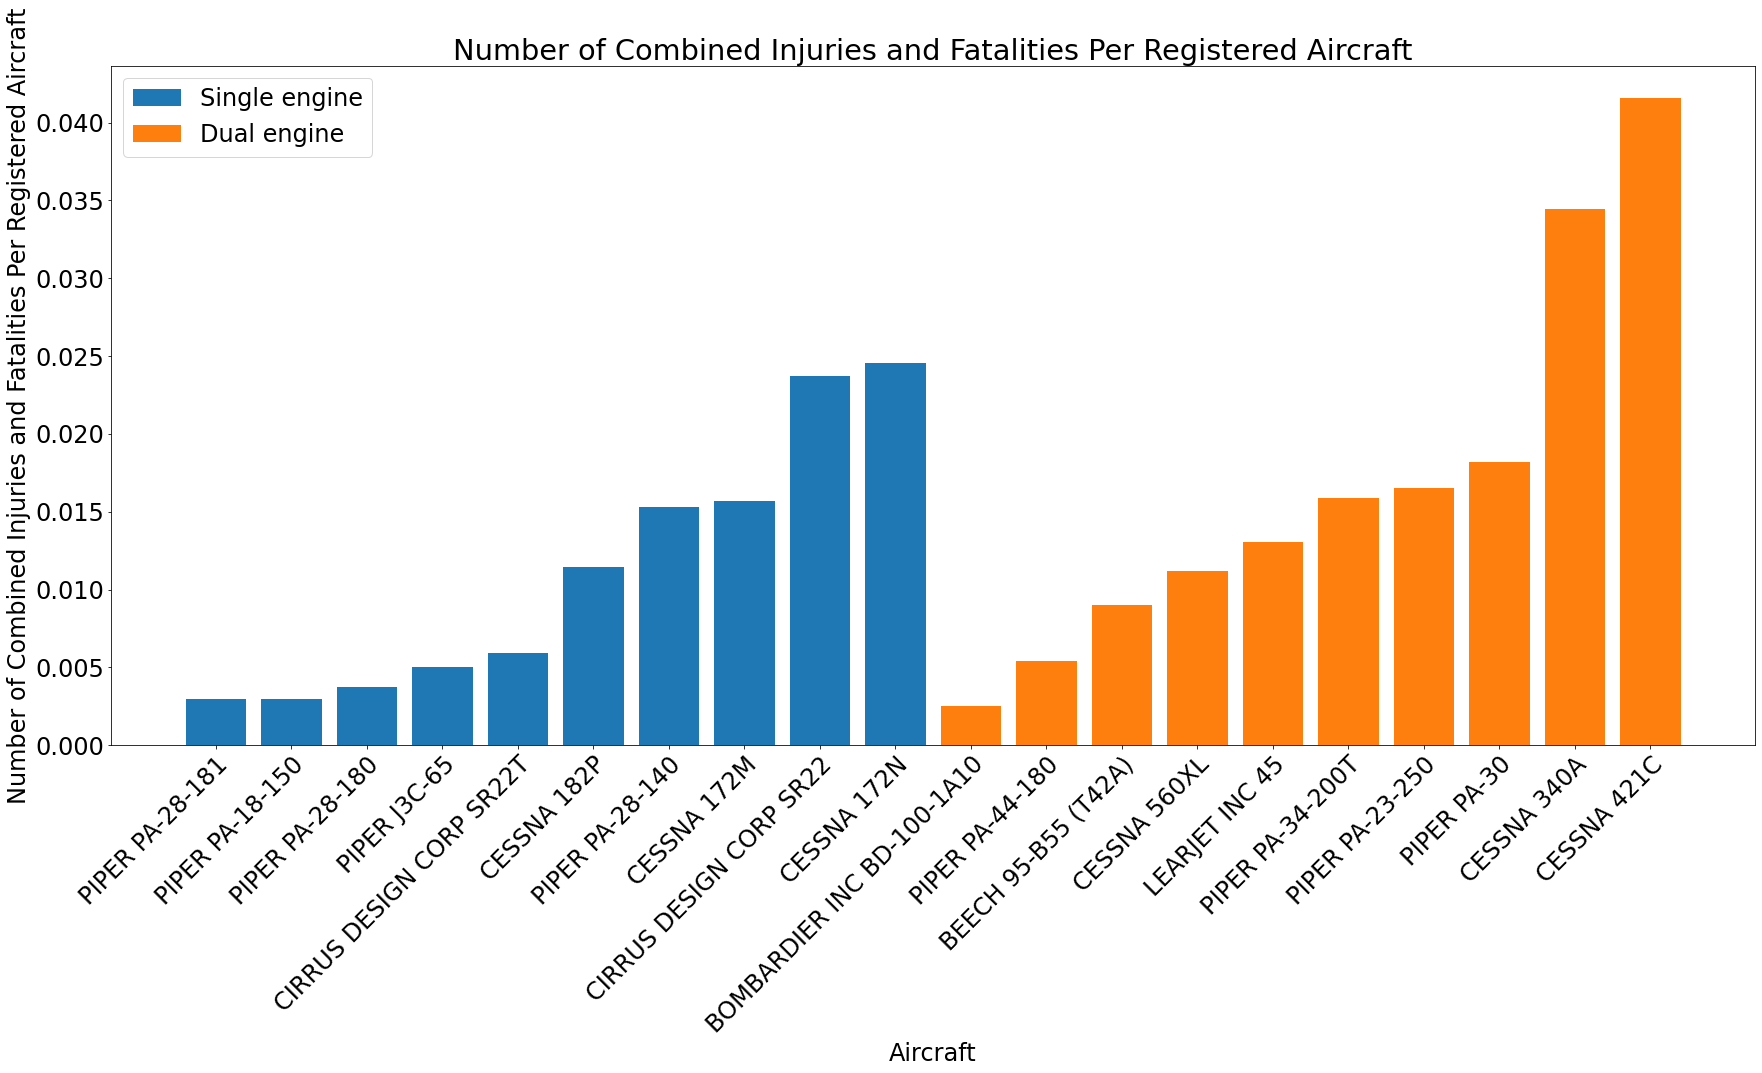

In [37]:
for_plotting = single_eng_top_ten.copy()
for_plotting['people_affected'] = for_plotting['fatalities.per.plane'] + for_plotting['serious.per.plane'] + for_plotting['minor.per.plane']
for_plotting = for_plotting.sort_values('people_affected')
x = for_plotting['make.model']
y = for_plotting['people_affected']

for_plotting2 = dual_eng_top_ten.copy()
for_plotting2['people_affected'] = for_plotting2['fatalities.per.plane'] + for_plotting2['serious.per.plane'] + for_plotting2['minor.per.plane']
for_plotting2 = for_plotting2.sort_values('people_affected')
x2 = for_plotting2['make.model']
y2 = for_plotting2['people_affected']

plt.figure(figsize=(25, 15))
plt.bar(x, y, label='Single engine')
plt.bar(x2, y2, label='Dual engine')
plt.xlabel("Aircraft")
plt.ylabel("Number of Combined Injuries and Fatalities Per Registered Aircraft")
plt.title("Number of Combined Injuries and Fatalities Per Registered Aircraft")
plt.xticks(rotation=45, ha="right", wrap=True)
plt.tight_layout()
plt.rcParams['font.size'] = 24
plt.legend()
plt.show()

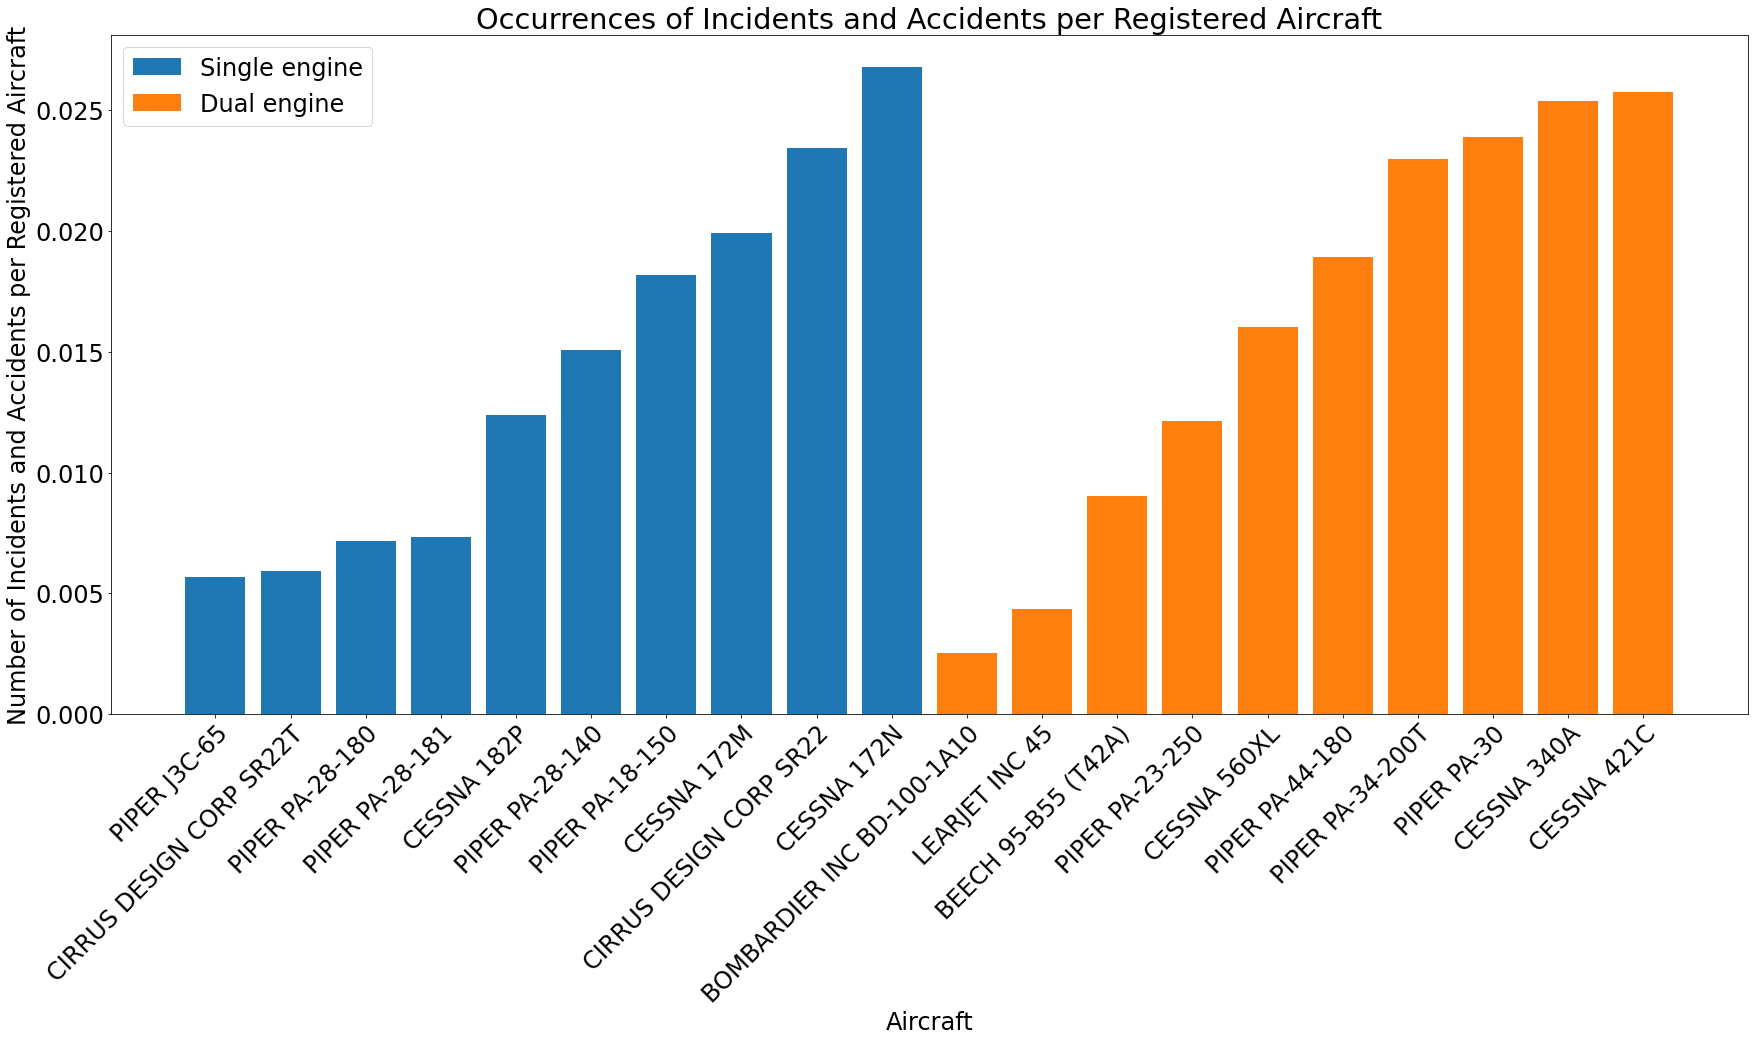

In [38]:
single_eng_top_ten.sort_values('occurrences.per.plane', inplace=True)
x = single_eng_top_ten['make.model']
y = single_eng_top_ten['occurrences.per.plane']
dual_eng_top_ten.sort_values('occurrences.per.plane', inplace=True)
x2 = dual_eng_top_ten['make.model']
y2 = dual_eng_top_ten['occurrences.per.plane']


plt.figure(figsize=(25, 15))
plt.bar(x, y, label='Single engine')
plt.bar(x2, y2, label='Dual engine')
plt.xlabel("Aircraft")
plt.ylabel("Number of Incidents and Accidents per Registered Aircraft")
plt.title("Occurrences of Incidents and Accidents per Registered Aircraft")
plt.xticks(rotation=45, ha="right", wrap=True)
plt.tight_layout()
plt.rcParams['font.size'] = 24
plt.legend()
plt.show()

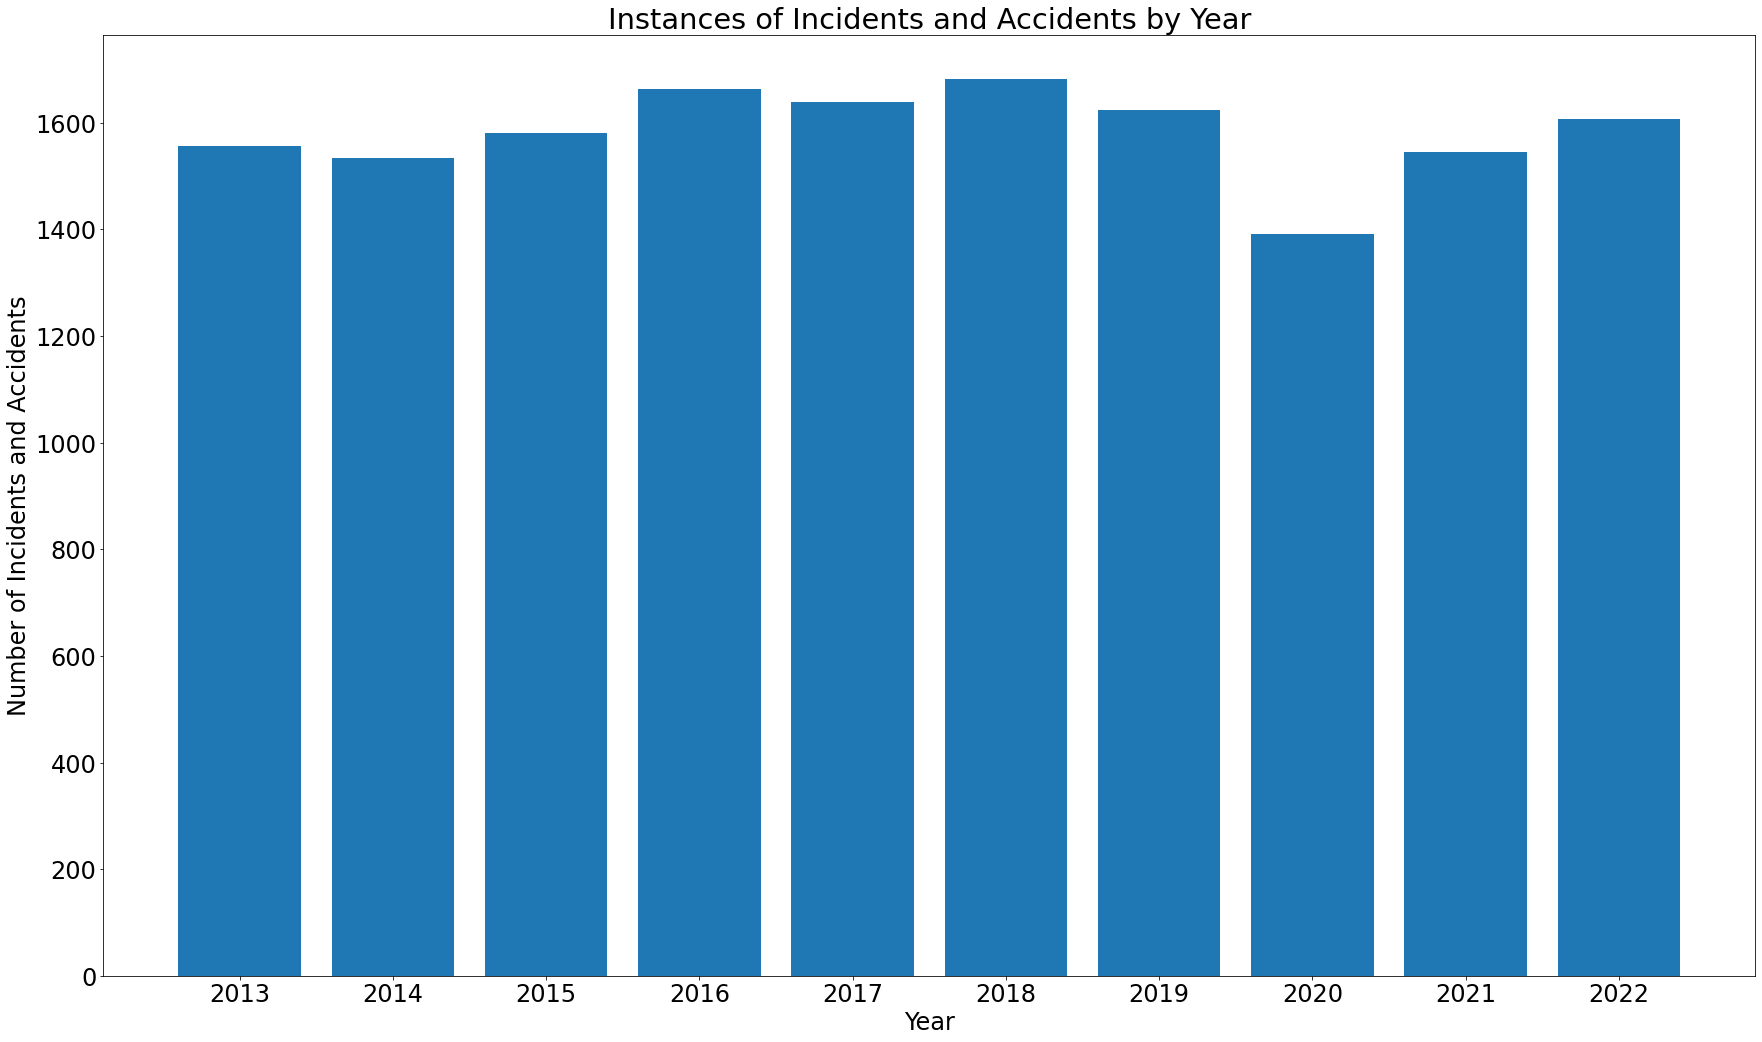

In [39]:
for_plotting = reduced_df.groupby(reduced_df['Event.Date'].dt.year).count()
x = for_plotting.index
y = for_plotting['Event.Date']
plt.figure(figsize=(25, 15))
plt.bar(x, y)
plt.xlabel("Year")
plt.ylabel("Number of Incidents and Accidents")
plt.title("Instances of Incidents and Accidents by Year")
plt.xticks(np.arange(len(x))+2013)  
plt.tight_layout()
plt.rcParams['font.size'] = 24
plt.show()

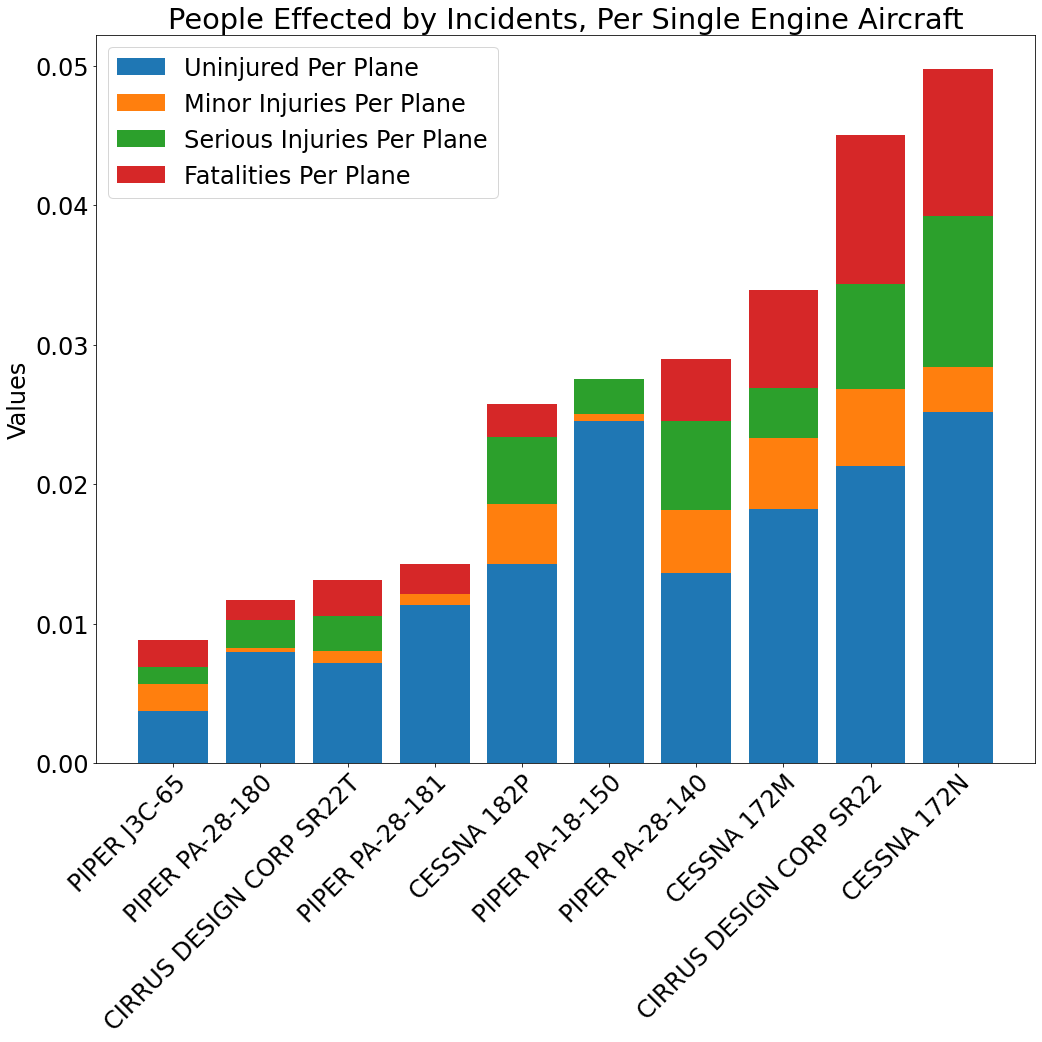

In [55]:
# Sort top ten list and define inputs for chart
single_eng_top_ten.sort_values('total.people.effected.per.plane', inplace=True)

categories = single_eng_top_ten['make.model']
group1_values = single_eng_top_ten['uninjured.per.plane']
group2_values = single_eng_top_ten['minor.per.plane']
group3_values = single_eng_top_ten['serious.per.plane']
group4_values = single_eng_top_ten['fatalities.per.plane']
g1_label = 'Uninjured Per Plane'
g2_label = 'Minor Injuries Per Plane'
g3_label = 'Serious Injuries Per Plane'
g4_label = 'Fatalities Per Plane'

# Create the stacked bar chart
plt.figure(figsize=(15, 15))

# Plotting each group and stacking them
plt.bar(categories, group1_values, label=g1_label)
plt.bar(categories, group2_values, bottom=group1_values, label=g2_label)
plt.bar(categories, group3_values, bottom=np.array(group1_values) + np.array(group2_values), label=g3_label)
plt.bar(categories, group4_values, bottom=np.array(group1_values) + np.array(group2_values) + np.array(group3_values), label=g4_label)

# Add labels, title, and legend
plt.ylabel("Values")
plt.title("People Effected by Incidents, Per Single Engine Aircraft")
plt.legend()
plt.xticks(rotation=45, ha="right", wrap=True)
plt.tight_layout()
plt.rcParams['font.size'] = 24

# Display the chart
plt.show()

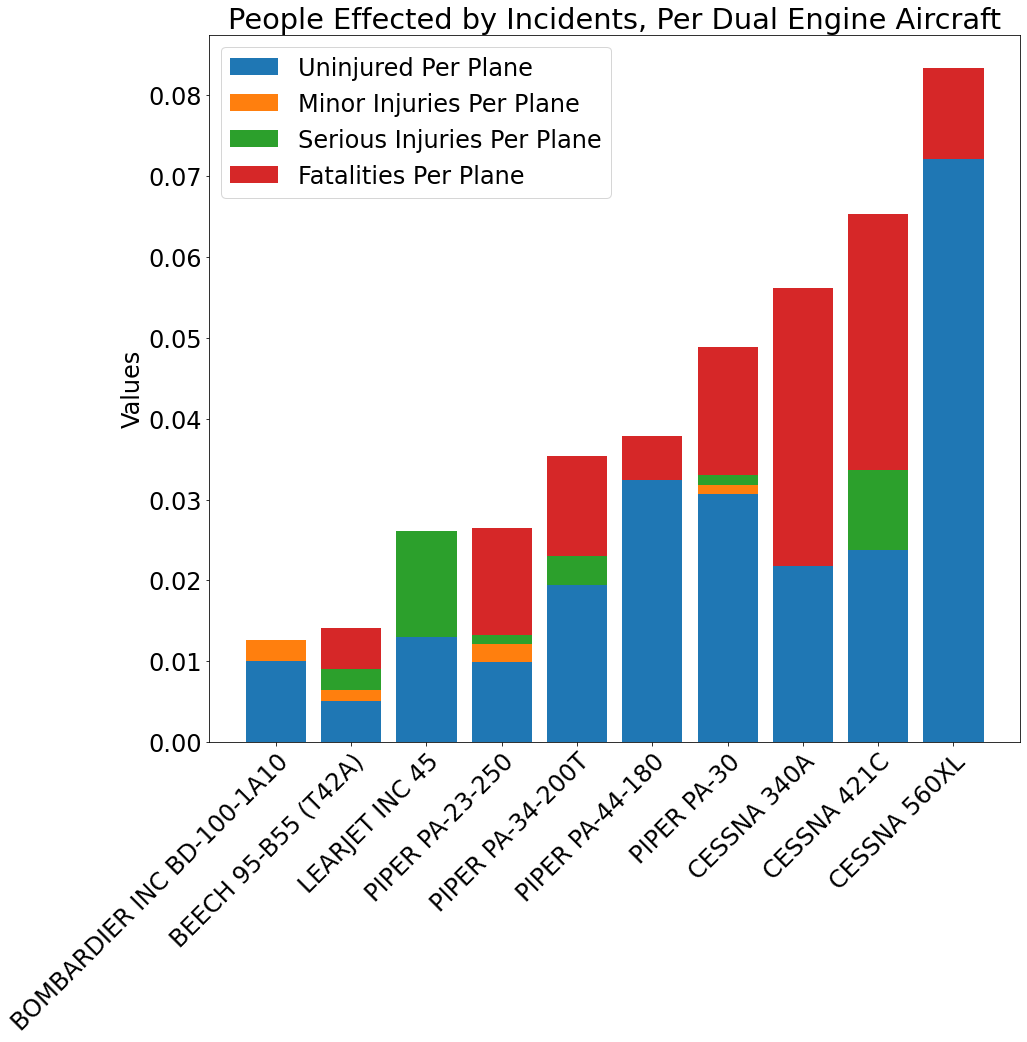

In [59]:
# Sort top ten list and define inputs for chart
dual_eng_top_ten.sort_values('total.people.effected.per.plane', inplace=True)

categories = dual_eng_top_ten['make.model']
group1_values = dual_eng_top_ten['uninjured.per.plane']
group2_values = dual_eng_top_ten['minor.per.plane']
group3_values = dual_eng_top_ten['serious.per.plane']
group4_values = dual_eng_top_ten['fatalities.per.plane']
g1_label = 'Uninjured Per Plane'
g2_label = 'Minor Injuries Per Plane'
g3_label = 'Serious Injuries Per Plane'
g4_label = 'Fatalities Per Plane'

# Create the stacked bar chart
plt.figure(figsize=(15, 15))

# Plotting each group and stacking them
plt.bar(categories, group1_values, label=g1_label)
plt.bar(categories, group2_values, bottom=group1_values, label=g2_label)
plt.bar(categories, group3_values, bottom=np.array(group1_values) + np.array(group2_values), label=g3_label)
plt.bar(categories, group4_values, bottom=np.array(group1_values) + np.array(group2_values) + np.array(group3_values), label=g4_label)

# Add labels, title, and legend
plt.ylabel("Values")
plt.title("People Effected by Incidents, Per Dual Engine Aircraft")
plt.legend()
plt.xticks(rotation=45, ha="right", wrap=True)
plt.tight_layout()
plt.rcParams['font.size'] = 24

# Display the chart
plt.show()

# Conclusion

## Limitations

## Recommendations

## Next Steps